## 先训练老师网络 

In [1]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import torch.utils.data
import numpy as np
import pandas as pd
from torch.utils.data import TensorDataset,DataLoader

torch.manual_seed(0)
torch.cuda.manual_seed(0)

In [2]:
## Load data

train = np.array(pd.read_csv('1Ddata_train_ver2.csv'))
test = np.array(pd.read_csv('1Ddata_test_ver2.csv'))

X_train = train[:,0:-1].reshape((-1, 1, 256))
y_train = train[:,-1]
X_test = test[:,0:-1].reshape((-1, 1, 256))
y_test = test[:,-1]

train_dataset = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train).long())
test_dataset = TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test).long())

batch_size = 50

dataloader = {"train": DataLoader(dataset=train_dataset,  # torch TensorDataset format
                                  batch_size=batch_size,  # mini batch size
                                  shuffle=True,
                                  num_workers=int(2),
                                  drop_last=True),
              "test": DataLoader(dataset=test_dataset,  # torch TensorDataset format
                                 batch_size=batch_size,  # mini batch size
                                 shuffle=True,
                                 num_workers=int(2),
                                 drop_last=False)}
classes = ('surface1', 'surface2', 'surface3')

In [3]:
class TeacherNet(nn.Module):
    def __init__(self):
        super(TeacherNet, self).__init__()
        
        # Instantiate two convolutional layers
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, stride=2, padding=1)
        # Instantiate dense layers
        self.fc1 = nn.Linear(16*128, 120)  #10x7x7 num_channel x height x width , orignal H/W 28 after two pooling, H/W = 7
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 3)
        # Instantiate the ReLU nonlinearity
        self.relu = nn.ReLU()        
        # Instantiate a max pooling layer
        self.pool = nn.MaxPool2d(2, 2)        


        
    def forward(self, x):

        # Apply conv followd by relu, then in next line pool
        x = self.relu(self.conv1(x))
        # Prepare the image for the fully connected layer
        x = torch.flatten(x, start_dim=1)
        x = self.fc1(x)
        x = self.fc2(x)       
        # Apply the fully connected layer and return the result
        return self.fc3(x)


def train_teacher(model, device, train_loader, optimizer, epoch):
    model.train()
    trained_samples = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()

        trained_samples += len(data)
        progress = math.ceil(batch_idx / len(train_loader) * 50)
        print("\rTrain epoch %d: %d/%d, [%-51s] %d%%" %
              (epoch, trained_samples, len(train_loader.dataset),
               '-' * progress + '>', progress * 2), end='')


def test_teacher(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    criterion = nn.CrossEntropyLoss()
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest: average loss: {:.4f}, accuracy: {}/{} ({:.0f}%)'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return test_loss, correct / len(test_loader.dataset)


In [4]:
def teacher_main(dataloader):
    epochs = 60
#     batch_size = 64
    torch.manual_seed(0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


#     #load data
#     train = np.array(pd.read_csv('1Ddata_train_ver2.csv'))
#     test = np.array(pd.read_csv('1Ddata_test_ver2.csv'))

#     X_train = train[:,0:-1].reshape((-1, 1, 256))
#     y_train = train[:,-1]
#     X_test = test[:,0:-1].reshape((-1, 1, 256))
#     y_test = test[:,-1]

#     train_dataset = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train).long())
#     test_dataset = TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test).long())

#     batch_size = 50

#     dataloader = {"train": DataLoader(dataset=train_dataset,  # torch TensorDataset format
#                                       batch_size=batch_size,  # mini batch size
#                                       shuffle=True,
#                                       num_workers=int(2),
#                                       drop_last=True),
#                   "test": DataLoader(dataset=test_dataset,  # torch TensorDataset format
#                                      batch_size=batch_size,  # mini batch size
#                                      shuffle=True,
#                                      num_workers=int(2),
#                                      drop_last=False)}
#     classes = ('surface1', 'surface2', 'surface3')    

    #     train_loader = torch.utils.data.DataLoader(
    #         datasets.MNIST('../data/MNIST', train=True, download=True,
    #                        transform=transforms.Compose([
    #                            transforms.ToTensor(),
    #                            transforms.Normalize((0.1307,), (0.3081,))
    #                        ])),
    #         batch_size=batch_size, shuffle=True)
    #     test_loader = torch.utils.data.DataLoader(
    #         datasets.MNIST('../data/MNIST', train=False, download=True, transform=transforms.Compose([
    #             transforms.ToTensor(),
    #             transforms.Normalize((0.1307,), (0.3081,))
    #         ])),
    #         batch_size=1000, shuffle=True)

    model = TeacherNet().to(device)
    optimizer = torch.optim.Adam(model.parameters())

    teacher_history = []

    for epoch in range(1, epochs + 1):
        train_teacher(model, device, dataloader["train"], optimizer, epoch)
        loss, acc = test_teacher(model, device, dataloader["test"])

        teacher_history.append((loss, acc))

    torch.save(model.state_dict(), "teacher.pt")
    return model, teacher_history

In [5]:
# 训练教师网络

teacher_model, teacher_history = teacher_main(dataloader)
# teacher_history

Train epoch 1: 1000/1049, [------------------------------------------------>  ] 96%
Test: average loss: 1.0468, accuracy: 217/449 (48%)
Train epoch 2: 1000/1049, [------------------------------------------------>  ] 96%
Test: average loss: 0.8851, accuracy: 277/449 (62%)
Train epoch 3: 1000/1049, [------------------------------------------------>  ] 96%
Test: average loss: 0.6409, accuracy: 329/449 (73%)
Train epoch 4: 1000/1049, [------------------------------------------------>  ] 96%
Test: average loss: 0.4794, accuracy: 360/449 (80%)
Train epoch 5: 1000/1049, [------------------------------------------------>  ] 96%
Test: average loss: 0.5542, accuracy: 318/449 (71%)
Train epoch 6: 1000/1049, [------------------------------------------------>  ] 96%
Test: average loss: 0.4179, accuracy: 370/449 (82%)
Train epoch 7: 1000/1049, [------------------------------------------------>  ] 96%
Test: average loss: 0.5307, accuracy: 328/449 (73%)
Train epoch 8: 1000/1049, [---------------------

Test: average loss: 0.4033, accuracy: 366/449 (82%)


## 小插曲，看看老师的暗知识 

In [6]:
import numpy as np
from matplotlib import pyplot as plt

def softmax_t(x, t):
    x_exp = np.exp(x / t)
    return x_exp / np.sum(x_exp)

# test_loader_bs1 = torch.utils.data.DataLoader(
#     datasets.MNIST('../data/MNIST', train=False, download=True, transform=transforms.Compose([
#         transforms.ToTensor(),
#         transforms.Normalize((0.1307,), (0.3081,))
#     ])),
#     batch_size=1, shuffle=True)

Output (NO softmax): [ 0.7889364  0.1060057 -1.9244622]


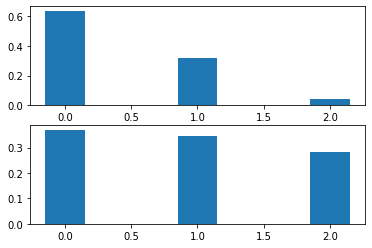

In [7]:
teacher_model.eval()
with torch.no_grad():
    data, target = next(iter(dataloader["test"]))
    data, target = data.to('cuda'), target.to('cuda')
    output = teacher_model(data)

test_x = data.cpu().numpy()
y_out = output.cpu().numpy()
y_out = y_out[0, ::]
print('Output (NO softmax):', y_out)



# plt.subplot(3, 1, 1)
# plt.imshow(test_x[0, 0, ::])

plt.subplot(2, 1, 1)
plt.bar(list(range(3)), softmax_t(y_out, 1), width=0.3)

plt.subplot(2, 1, 2)
plt.bar(list(range(3)), softmax_t(y_out, 10), width=0.3)
plt.show()

# 让老师教学生网络 

In [8]:
class StudentNet(nn.Module):
    def __init__(self):
        super(StudentNet, self).__init__()
        self.fc1 = nn.Linear(256 * 1, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 3)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

### 关键，定义kd的loss 

In [9]:
def distillation(y, labels, teacher_scores, temp, alpha):
    return nn.KLDivLoss()(F.log_softmax(y / temp, dim=1), F.softmax(teacher_scores / temp, dim=1)) * (
            temp * temp * 2.0 * alpha) + F.cross_entropy(y, labels) * (1. - alpha)


In [10]:
def train_student_kd(model, device, train_loader, optimizer, epoch):
    model.train()
    trained_samples = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
#         data_stu = data.view(-1,256*1)
        optimizer.zero_grad()
        output = model(data)
#         print(output.shape)
#         print(target.shape)
        teacher_output = teacher_model(data)
        teacher_output = teacher_output.detach()  # 切断老师网络的反向传播，感谢B站“淡淡的落”的提醒
#         print(teacher_output.shape)
        loss = distillation(output, target, teacher_output, temp=5.0, alpha=0.7)
        loss.backward()
        optimizer.step()

        trained_samples += len(data)
        progress = math.ceil(batch_idx / len(train_loader) * 50)
        print("\rTrain epoch %d: %d/%d, [%-51s] %d%%" %
              (epoch, trained_samples, len(train_loader.dataset),
               '-' * progress + '>', progress * 2), end='')


def test_student_kd(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
#             data_stu = data.view(-1,256*1)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest: average loss: {:.4f}, accuracy: {}/{} ({:.0f}%)'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return test_loss, correct / len(test_loader.dataset)

In [11]:
def student_kd_main(dataloader):
    epochs = 100
    torch.manual_seed(0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    
    
#     #load data
#     train = np.array(pd.read_csv('1Ddata_train_ver2.csv'))
#     test = np.array(pd.read_csv('1Ddata_test_ver2.csv'))

#     #train = train.reshape((train.shape[0], 1, 257))
#     #test = test.reshape((test.shape[0], 1, 257))

#     X_train = train[:,0:-1].reshape((-1, 1, 256))
#     y_train = train[:,-1]
#     X_test = test[:,0:-1].reshape((-1, 1, 256))
#     y_test = test[:,-1]

#     #reproducibility
#     torch.manual_seed(0)


#     train_dataset = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train).long())
#     test_dataset = TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test).long())

#     batch_size = 50

#     dataloader = {"train": DataLoader(dataset=train_dataset,  # torch TensorDataset format
#                                       batch_size=batch_size,  # mini batch size
#                                       shuffle=True,
#                                       num_workers=int(2),
#                                       drop_last=False),
#                   "test": DataLoader(dataset=test_dataset,  # torch TensorDataset format
#                                      batch_size=batch_size,  # mini batch size
#                                      shuffle=True,
#                                      num_workers=int(2),
#                                      drop_last=False)}
#     classes = ('surface1', 'surface2', 'surface3') 




#     train_loader = torch.utils.data.DataLoader(
#         datasets.MNIST('../data/MNIST', train=True, download=True,
#                        transform=transforms.Compose([
#                            transforms.ToTensor(),
#                            transforms.Normalize((0.1307,), (0.3081,))
#                        ])),
#         batch_size=batch_size, shuffle=True)
#     test_loader = torch.utils.data.DataLoader(
#         datasets.MNIST('../data/MNIST', train=False, download=True, transform=transforms.Compose([
#             transforms.ToTensor(),
#             transforms.Normalize((0.1307,), (0.3081,))
#         ])),
#         batch_size=1000, shuffle=True)

    model = StudentNet().to(device)
    optimizer = torch.optim.Adadelta(model.parameters())
    
    student_history = []
    for epoch in range(1, epochs + 1):
        train_student_kd(model, device, dataloader["train"], optimizer, epoch)
        loss, acc = test_student_kd(model, device, dataloader["test"])
        student_history.append((loss, acc))

    torch.save(model.state_dict(), "student_kd.pt")
    return model, student_history

In [12]:
student_kd_model, student_kd_history = student_kd_main(dataloader)

C:\Users\zhshi\AppData\Local\Continuum\anaconda3\lib\site-packages\torch\nn\functional.py:2748: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  "reduction: 'mean' divides the total loss by both the batch size and the support size."


Train epoch 1: 1000/1049, [------------------------------------------------>  ] 96%
Test: average loss: 1.0867, accuracy: 149/449 (33%)
Train epoch 2: 1000/1049, [------------------------------------------------>  ] 96%
Test: average loss: 1.0697, accuracy: 159/449 (35%)
Train epoch 3: 1000/1049, [------------------------------------------------>  ] 96%
Test: average loss: 1.0829, accuracy: 153/449 (34%)
Train epoch 4: 1000/1049, [------------------------------------------------>  ] 96%
Test: average loss: 0.9892, accuracy: 222/449 (49%)
Train epoch 5: 1000/1049, [------------------------------------------------>  ] 96%
Test: average loss: 1.2927, accuracy: 168/449 (37%)
Train epoch 6: 1000/1049, [------------------------------------------------>  ] 96%
Test: average loss: 1.1747, accuracy: 172/449 (38%)
Train epoch 7: 1000/1049, [------------------------------------------------>  ] 96%
Test: average loss: 1.3899, accuracy: 161/449 (36%)
Train epoch 8: 1000/1049, [---------------------

Test: average loss: 0.7170, accuracy: 298/449 (66%)
Train epoch 61: 1000/1049, [------------------------------------------------>  ] 96%
Test: average loss: 0.6705, accuracy: 316/449 (70%)
Train epoch 62: 1000/1049, [------------------------------------------------>  ] 96%
Test: average loss: 0.8896, accuracy: 301/449 (67%)
Train epoch 63: 1000/1049, [------------------------------------------------>  ] 96%
Test: average loss: 0.7108, accuracy: 319/449 (71%)
Train epoch 64: 1000/1049, [------------------------------------------------>  ] 96%
Test: average loss: 0.7348, accuracy: 300/449 (67%)
Train epoch 65: 1000/1049, [------------------------------------------------>  ] 96%
Test: average loss: 0.6900, accuracy: 322/449 (72%)
Train epoch 66: 1000/1049, [------------------------------------------------>  ] 96%
Test: average loss: 1.0199, accuracy: 288/449 (64%)
Train epoch 67: 1000/1049, [------------------------------------------------>  ] 96%
Test: average loss: 0.6689, accuracy: 314

In [13]:
## 让学生自己学，不使用KD
def train_student(model, device, train_loader, optimizer, epoch):
    model.train()
    trained_samples = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
#         data = data.view(-1,256*1) #change data shape (MLP needed)
        optimizer.zero_grad()
        output = model(data)
        # print(output)
        # a
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()

        trained_samples += len(data)
        progress = math.ceil(batch_idx / len(train_loader) * 50)
        print("\rTrain epoch %d: %d/%d, [%-51s] %d%%" %
              (epoch, trained_samples, len(train_loader.dataset),
               '-' * progress + '>', progress * 2), end='')


def test_student(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
#             data = data.view(-1,256*1) #change data shape (MLP needed)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest: average loss: {:.4f}, accuracy: {}/{} ({:.0f}%)'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return test_loss, correct / len(test_loader.dataset)

In [14]:
def student_main(dataloader):
    epochs = 100
    torch.manual_seed(0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#     train = np.array(pd.read_csv('1Ddata_train_ver2.csv'))
#     test = np.array(pd.read_csv('1Ddata_test_ver2.csv'))

#     #train = train.reshape((train.shape[0], 1, 257))
#     #test = test.reshape((test.shape[0], 1, 257))

#     X_train = train[:,0:-1].reshape((-1, 1, 256))
#     y_train = train[:,-1]
#     X_test = test[:,0:-1].reshape((-1, 1, 256))
#     y_test = test[:,-1]

#     #reproducibility
#     torch.manual_seed(0)


#     train_dataset = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train).long())
#     test_dataset = TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test).long())

#     batch_size = 50

#     dataloader = {"train": DataLoader(dataset=train_dataset,  # torch TensorDataset format
#                                       batch_size=batch_size,  # mini batch size
#                                       shuffle=True,
#                                       num_workers=int(2),
#                                       drop_last=False),
#                   "test": DataLoader(dataset=test_dataset,  # torch TensorDataset format
#                                      batch_size=batch_size,  # mini batch size
#                                      shuffle=True,
#                                      num_workers=int(2),
#                                      drop_last=False)}
#     classes = ('surface1', 'surface2', 'surface3')

    model = StudentNet().to(device)
    optimizer = torch.optim.Adam(model.parameters())

    student_history = []

    for epoch in range(1, epochs + 1):
        train_student(model, device, dataloader['train'], optimizer, epoch)
        loss, acc = test_student(model, device, dataloader['test'])
        student_history.append((loss, acc))

    torch.save(model.state_dict(), "student.pt")
    return model, student_history

In [ ]:
student_simple_model, student_simple_history = student_main(dataloader)

Train epoch 1: 1000/1049, [------------------------------------------------>  ] 96%
Test: average loss: 1.0936, accuracy: 149/449 (33%)
Train epoch 2: 1000/1049, [------------------------------------------------>  ] 96%
Test: average loss: 1.0630, accuracy: 234/449 (52%)
Train epoch 3: 1000/1049, [------------------------------------------------>  ] 96%
Test: average loss: 1.0030, accuracy: 238/449 (53%)
Train epoch 4: 1000/1049, [------------------------------------------------>  ] 96%
Test: average loss: 0.9363, accuracy: 247/449 (55%)
Train epoch 5: 1000/1049, [------------------------------------------------>  ] 96%
Test: average loss: 0.8828, accuracy: 245/449 (55%)
Train epoch 6: 1000/1049, [------------------------------------------------>  ] 96%
Test: average loss: 0.8226, accuracy: 276/449 (61%)
Train epoch 7: 1000/1049, [------------------------------------------------>  ] 96%
Test: average loss: 0.8857, accuracy: 249/449 (55%)
Train epoch 8: 1000/1049, [---------------------

Test: average loss: 0.6359, accuracy: 316/449 (70%)
Train epoch 61: 1000/1049, [------------------------------------------------>  ] 96%
Test: average loss: 0.5776, accuracy: 337/449 (75%)
Train epoch 62: 1000/1049, [------------------------------------------------>  ] 96%
Test: average loss: 0.6314, accuracy: 319/449 (71%)
Train epoch 63: 1000/1049, [------------------------------------------------>  ] 96%
Test: average loss: 0.5878, accuracy: 318/449 (71%)
Train epoch 64: 1000/1049, [------------------------------------------------>  ] 96%
Test: average loss: 0.5840, accuracy: 337/449 (75%)
Train epoch 65: 1000/1049, [------------------------------------------------>  ] 96%
Test: average loss: 0.6248, accuracy: 312/449 (69%)
Train epoch 66: 1000/1049, [------------------------------------------------>  ] 96%
Test: average loss: 0.5976, accuracy: 328/449 (73%)
Train epoch 67: 1000/1049, [------------------------------------------------>  ] 96%
Test: average loss: 0.5757, accuracy: 335

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [ ]:



# plt.subplot(2, 1, 1)

# plt.plot(x, [teacher_history[i][1] for i in range(epochs)], label='teacher')
# plt.plot(x, [student_kd_history[i][1] for i in range(epochs)], label='student with KD')
# plt.plot(x, [student_simple_history[i][1] for i in range(epochs)], label='student without KD')

# plt.title('Test accuracy')
# plt.legend()


# plt.subplot(2, 1, 2)
# plt.plot(x, [teacher_history[i][0] for i in range(epochs)], label='teacher')
# plt.plot(x, [student_kd_history[i][0] for i in range(epochs)], label='student with KD')
# plt.plot(x, [student_simple_history[i][0] for i in range(epochs)], label='student without KD')

# plt.title('Test loss')
# plt.legend()




In [ ]:
epochs = 60
x = list(range(1, epochs+1))

#multiple plots in 1 fig
fig,ax=plt.subplots(2,1,figsize=(12,12),dpi=80)


ax[0].plot([teacher_history[i][1] for i in range(epochs)], label='teacher')
ax[0].plot([student_kd_history[i][1] for i in range(epochs)], label='student with KD')
ax[0].plot([student_simple_history[i][1] for i in range(epochs)], label='student without KD')

ax[0].set_title('Test accuracy')
ax[0].legend()


# plt.subplot(2, 1, 2)
ax[1].plot([teacher_history[i][0] for i in range(epochs)], label='teacher')
ax[1].plot([student_kd_history[i][0] for i in range(epochs)], label='student with KD')
ax[1].plot([student_simple_history[i][0] for i in range(epochs)], label='student without KD')

ax[1].set_title('Test loss')
ax[1].legend()
